In [602]:
import io

import cv2
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [603]:
obs_list = [
    [
        {
            "action": "EAST",
            "reward": 902,
            "info": {},
            "observation": {
                "remainingOverageTime": 60,
                "step": 8,
                "geese": [[53, 54], [65], [7, 73, 72], [2, 3, 4]],
                "food": [29, 71],
                "index": 0,
            },
            "status": "ACTIVE",
        },
        {
            "action": "NORTH",
            "reward": 901,
            "info": {},
            "observation": {"remainingOverageTime": 60, "index": 1},
            "status": "ACTIVE",
        },
        {
            "action": "EAST",
            "reward": 903,
            "info": {},
            "observation": {"remainingOverageTime": 60, "index": 2},
            "status": "ACTIVE",
        },
        {
            "action": "EAST",
            "reward": 903,
            "info": {},
            "observation": {"remainingOverageTime": 60, "index": 3},
            "status": "ACTIVE",
        },
    ],
    [
        {
            "action": "EAST",
            "reward": 1002,
            "info": {},
            "observation": {
                "remainingOverageTime": 60,
                "step": 9,
                "geese": [[56, 55, 44, 33], [66, 67, 68, 69], [8, 7, 73, 72, 71], [1, 2, 3, 4, 5]],
                "food": [29, 60],
                "index": 0,
            },
            "status": "ACTIVE",
        },
        {
            "action": "NORTH",
            "reward": 1001,
            "info": {},
            "observation": {"remainingOverageTime": 60, "index": 1},
            "status": "ACTIVE",
        },
        {
            "action": "EAST",
            "reward": 1003,
            "info": {},
            "observation": {"remainingOverageTime": 60, "index": 2},
            "status": "ACTIVE",
        },
        {
            "action": "EAST",
            "reward": 1003,
            "info": {},
            "observation": {"remainingOverageTime": 60, "index": 3},
            "status": "ACTIVE",
        },
    ],
]

In [604]:
class GeeseImage:
    GOOSE_ID_TO_COLOR = {0: "blue", 1: "orange", 2: "orange", 3: "orange"}
    FOOD_COLOR = "green"
    NUM_AGENTS = 4
    NUM_ROW, NUM_COL = 7, 11

    def __init__(self, **kwargs):
        width = 1.08
        height = 0.69
        padding = 0.0

        self.fig = plt.figure(figsize=(width, height), facecolor=(1, 1, 1))
        plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
        ax = plt.axes()
        plt.axis("off")

        self.plot_objects = self.init_func(ax, padding=padding, **kwargs)

    def flat_to_point(self, _x):
        assert 0 <= _x < self.NUM_COL * self.NUM_ROW
        return _x % self.NUM_COL, self.NUM_ROW - _x // self.NUM_COL - 1

    def food_positions(self, state):
        points = state[0]["observation"]["food"]
        points = [self.flat_to_point(x) for x in points]
        assert len(points) == 2
        x, y = [x[0] for x in points], [x[1] for x in points]
        if x[0] == x[1] and y[0] == y[1]:
            x[0] -= 0.25
            x[1] += 0.25
        return x, y

    def player_positions(self, state, goose_id: int):
        points = state[0]["observation"]["geese"][goose_id]
        points = [self.flat_to_point(x) for x in points]

        if len(points) == 0:
            return [], []

        if len(points) == 1:
            return [points[0][0]], [points[0][1]]

        last_x, last_y = points[0][0], points[0][1]
        xx, yy = [last_x], [last_y]
        for p in points[1:]:
            x, y = p[0], p[1]

            if x == 0 and last_x == self.NUM_COL - 1:
                xx += [self.NUM_COL + 2, self.NUM_COL + 2, -2, -2]
                yy += [y, -2, -2, y]

            if x == self.NUM_COL - 1 and last_x == 0:
                xx += [-2, -2, self.NUM_COL + 2, self.NUM_COL + 2]
                yy += [y, -2, -2, y]

            if y == 0 and last_y == self.NUM_ROW - 1:
                xx += [x, -2, -2, x]
                yy += [self.NUM_ROW + 2, self.NUM_ROW + 2, -2, -2]

            if y == self.NUM_ROW - 1 and last_y == 0:
                xx += [x, -2, -2, x]
                yy += [-2, -2, self.NUM_ROW + 2, self.NUM_ROW + 2]

            xx.append(x)
            yy.append(y)
            last_x, last_y = x, y

        return xx, yy

    def head_positions(self, state, goose_id: int):
        points = state[0]["observation"]["geese"][goose_id]
        points = [self.flat_to_point(x) for x in points]
        return [x[0] for x in points[:1]], [x[1] for x in points[:1]]

    def init_func(self, ax, padding=0.5):
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_ylim(-0.5 - padding, self.NUM_ROW - 0.5 + padding)
        ax.set_xlim(-0.5 - padding, self.NUM_COL - 0.5 + padding)

        # FOOD
        food, *_ = ax.plot([], [], "D", color=self.FOOD_COLOR, ms=4)

        # GEESE
        geese = []
        heads = []
        for i in range(self.NUM_AGENTS):
            color = self.GOOSE_ID_TO_COLOR[i]
            g, *_ = ax.plot([], [], color=color)
            g.set_linewidth(2)
            h, *_ = ax.plot([], [], "o", color=color, ms=4)
            geese.append(g)
            heads.append(h)

        return food, geese, heads

    def to_image(self, state, player=0):
        food, geese, heads = self.plot_objects

        # FOOD
        food.set_data(self.food_positions(state))

        # GEESE
        for i in range(self.NUM_AGENTS):
            geese[(i - player) % self.NUM_AGENTS].set_data(self.player_positions(state, i))
            heads[(i - player) % self.NUM_AGENTS].set_data(self.head_positions(state, i))

        return (food, *geese, *heads)

    def to_numpy(self, state, player=0):
        self.to_image(state, player)

        buf = io.BytesIO()
        self.fig.savefig(buf, format="png")

        buf.seek(0)
        img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
        buf.close()

        img = cv2.imdecode(img_arr, 1)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        return img

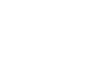

In [605]:
gm = GeeseImage()

In [606]:
img = gm.to_numpy(obs_list[1], 3)

In [607]:
img.shape

(49, 77)

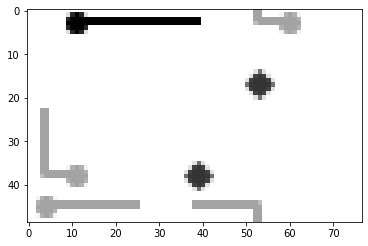

In [608]:
# plt.imshow(img)
plt.imshow(img, cmap="gray")

plt.show()

In [609]:
img[43]

array([255, 255, 244, 186, 174, 186, 244, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
      dtype=uint8)